# Predict the survival on the Titanic

Data Dictionary:

| Variable | Definition | Key |
| --- | --- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age | in years |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation |C = Cherbourg, Q = Queenstown, S = Southampton |


**Variable Notes**

*pclass*: A proxy for socio-economic status (SES)
- 1st = Upper
- 2nd = Middle
- 3rd = Lower

*age*: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

*sibsp*: The dataset defines family relations in this way...
- Sibling = brother, sister, stepbrother, stepsister
- Spouse = husband, wife (mistresses and fiancés were ignored)

*parch*: The dataset defines family relations in this way...
- Parent = mother, father
- Child = daughter, son, stepdaughter, stepson
- Some children travelled only with a nanny, therefore parch=0 for them.

## Read the data

In [1]:
import pandas as pd

train = pd.read_csv("train.csv")
holdout = pd.read_csv("test.csv")

train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S

## Preprocessing the Data

In [2]:
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

Preprocessing the data by filling some missing values and 
transforming some continuous numeric columns to categorial columns

1. Handling various missing values from the data set 
    - Fill all the missing values in `Fare` column to their mean
    - Fill all the missing values in `Embarked` column to value `S`
2. Processing the `Age` column into pre-defined bins
3. Processing the `Fare` column into pre-defined bins
4. Extracting and categorizing the new `title` column from the `name` column
5. Processing the `Cabin` column into pre-defined bins

In [3]:
def pre_process(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)

    for col in ["Age_categories",
                "Fare_categories",
                "Title",
                "Cabin_type",
                "Sex"]:
        df = create_dummies(df,col)
    
    return df

train = pre_process(train)
holdout = pre_process(holdout)

## Exploring the Data
Examine the two columns that contain information about the family members each passenger had onboard: **SibSp** and **Parch**

In [4]:
# Inspect the type of columns
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()
explore.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 3 columns):
SibSp       891 non-null int64
Parch       891 non-null int64
Survived    891 non-null int64
dtypes: int64(3)
memory usage: 21.0 KB


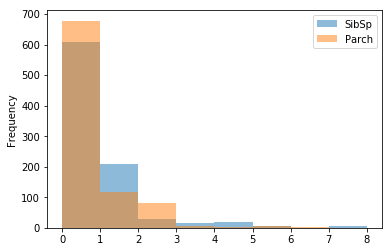

In [5]:
# View the distribution of values in columns
import matplotlib.pyplot as plt
%matplotlib inline

explore.drop('Survived', axis=1).plot.hist(alpha=0.5,bins=8)
plt.show()

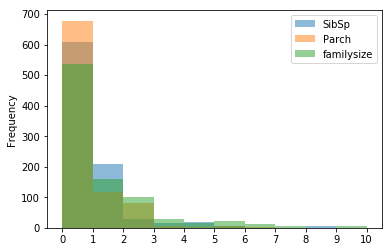

In [6]:
# Combine the columns + look at the resulting 
# distribution of values and survival rate
explore["familysize"] = explore[["SibSp","Parch"]].sum(axis=1)
explore.drop("Survived",axis=1).plot.hist(alpha=0.5,bins=10)
plt.xticks(range(11))
plt.show()

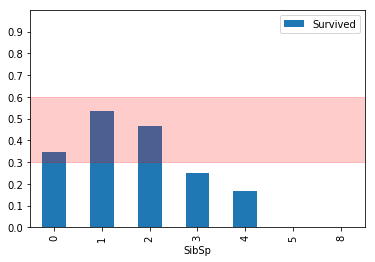

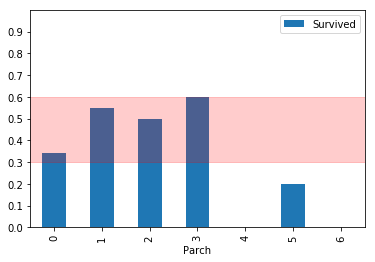

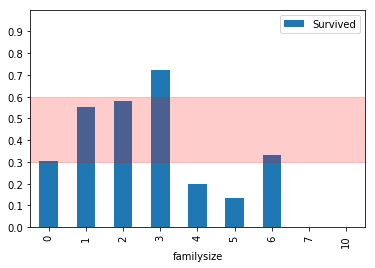

In [7]:
# Look at closely survival rate for 
# different values of the column
import numpy as np

for col in explore.columns.drop("Survived"):
    pivot = explore.pivot_table(index=col,values="Survived")
    pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
    plt.axhspan(.3, .6, alpha=0.2, color='red')
    plt.show()

In [8]:
# Explore the data with familysize = 0
print('Familysize value counts:')
print(explore['familysize'].value_counts(normalize=False))
print('Number of persons with no family: {}'
      .format(len(explore[explore['familysize'] == 0])))
print('Number of persons with no family survived: {}'
      .format(len(explore[(explore['familysize'] == 0) 
            & (explore['Survived'] == 1)])))

Familysize value counts:
0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: familysize, dtype: int64
Number of persons with no family: 537
Number of persons with no family survived: 163


The `SibSp` column shows the number of siblings and/or spouses each passenger had on board, while the `Parch` columns shows the number of parents or children each passenger had onboard. Neither column has any missing values.

The distribution of values in both columns is skewed right, with the majority of values being zero.

Summing these two columns to explore the total number of family members each passenger had onboard. The shape of the distribution of values in this case is similar, however there are less values at zero, and the quantity goes less rapidly as the values increase.

Looking at the survival rates of the the combined family members, there are few (163) of 537 passengers with no family members survived, while greater numbers of passengers with family members survived.

## Engineering New Features

As described above, only 30% of the passengers who had no family members onboard survived. Based of this, we can come up with an idea for a new feature - was the passenger alone. This will be a binary column containing the value:

- 1 if the passenger has zero family members onboard
- 0 if the passenger has one or more family members onboard

In [9]:
def process_isalone(df):
    df['familysize'] = df[["SibSp","Parch"]].sum(axis=1)
    df['isalone'] = 0
    df.loc[(df['familysize'] == 0), 'isalone'] = 1
    df = df.drop('familysize',axis=1)
    return df

train = process_isalone(train)
holdout = process_isalone(holdout)

train.head(5)

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare   ...    Cabin_type_C Cabin_type_D  \
0      0         A/5 21171   7.2500   ...               0            0   
1      0          PC 17599  71.2833   ...               1            0   
2      0  STON/O2. 3101282   7.9250   ...               0            0   
3      0            113803  53.1000   ...               1            0   
4      0            373450   8.0500   ...               0            0   

  Cabin_type_E Cabin_type_F Cabin_type_G  Cabin_type_T  Cabin_type_Unknown  \
0            0            0            0             0                   1   
1            0            0            0             0                   0   
2            0            0            0             0                   1   
3            0            0            0             0                   0   
4            0            0            0             0                   1   

   Sex_female  Sex_male  isalone  
0           0         1        0  
1           1         0        0  
2           1         0        1  
3           1         0        0  
4           0         1        1  

[5 rows x 44 columns]

## Select the best-performing features

Feature ranking with recursive feature elimination and cross-validated selection of the best number of features
using the best estimator: RandomForest

In [10]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

def select_features(df):
    # Removes any non-numeric columns or columns containing null values
    df = df.select_dtypes(include=[np.number]).dropna(axis=1)
    # Exclude `PassengerId` + `Survived` columns
    all_X = df.drop(["Survived","PassengerId"],axis=1)
    all_y = df["Survived"]

    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    
    best_columns = list(all_X.columns[selector.support_])
    print("Best columns \n" + '-' * 12 + "\n{}\n".format(best_columns))
    return best_columns

cols = select_features(train)

Best columns 
------------
['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing', 'Age_categories_Infant', 'Age_categories_Young Adult', 'Fare_categories_12-50', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male', 'isalone']



## Select and tuning different algorithms

Apply logistic regression, K-Nearest neighbor and RandomForest algorithms with different hyperparameters
to find the best estimator and their corresponding parameters

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

def select_model(df,features):
    
    all_X = df[features]
    all_y = df["Survived"]

    # List of dictionaries, each containing a model name,
    # it's estimator and a dict of hyperparameters
    models = [
        {
            "name": "LogisticRegression",
            "estimator": LogisticRegression(),
            "hyperparameters":
                {
                    "solver": ["newton-cg", "lbfgs", "liblinear"]
                }
        },
        {
            "name": "KNeighborsClassifier",
            "estimator": KNeighborsClassifier(),
            "hyperparameters":
                {
                    "n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]
                }
        },
        {
            "name": "RandomForestClassifier",
            "estimator": RandomForestClassifier(random_state=1),
            "hyperparameters":
                {
                    "n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]

                }
        }
    ]

    for model in models:
        print(model['name'])
        print('-'*len(model['name']))

        grid = GridSearchCV(model["estimator"],
                            param_grid=model["hyperparameters"],
                            cv=10)
        grid.fit(all_X,all_y)
        
        model["best_params"] = grid.best_params_
        model["best_score"] = grid.best_score_
        model["best_model"] = grid.best_estimator_

        print("Best Score: {}".format(model["best_score"]))
        print("Best Parameters: {}\n".format(model["best_params"]))

    return models

result = select_model(train, cols)

LogisticRegression
------------------
Best Score: 0.8204264870931538
Best Parameters: {'solver': 'liblinear'}

KNeighborsClassifier
--------------------
Best Score: 0.7755331088664422
Best Parameters: {'algorithm': 'brute', 'n_neighbors': 5, 'p': 1, 'weights': 'uniform'}

RandomForestClassifier
----------------------
Best Score: 0.8294051627384961
Best Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 4}



## Save submission file to Kaggle

In [12]:
from sklearn.model_selection import cross_val_score

def save_submission_file(model, columns, filename="submission.csv"):
    print('Training accuracy score: {}'
          .format(cross_val_score(model, train[columns], train['Survived'], cv=10).mean()))
    
    holdout_data = holdout[columns]
    predictions = model.predict(holdout_data)
    
    submission = pd.DataFrame({
        'PassengerId' : holdout['PassengerId'],
        'Survived' : predictions
    })
    
    submission.to_csv(filename, index=False)

best_rf_model = result[2]['best_model']
save_submission_file(best_rf_model, cols)

Training accuracy score: 0.8294597662013393
